In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Parses a Block number log line. Returns the block number if it's a valid log. Returns None otherwise.
def new_block_number(log):
    add_pattern = re.compile(r"Adding block ([\d.]+) with hash")
    match = add_pattern.search(log)
    if match:
        return int(match.group(1))

In [3]:
# Parses a metrics log line. Returns a struct with metrics. Returns None if this is not a metrics log.
def metrics_log(log):
    # Older log structure
    pattern = re.compile(
        r"\[METRIC\] BLOCK EXECUTION THROUGHPUT \(([\d]+)\): ([\d.]+) Ggas/s TIME SPENT: ([\d]+) ms. #Txs: ([\d]+). exec/Ggas: ([\d]+) ms \(([\d]+)%\), st/Ggas: ([\d]+) ms \(([\d]+)%\)"
    )

    # Logs after separating merkelization.
    pattern_2 = re.compile(
        r"\[METRIC\] BLOCK EXECUTION THROUGHPUT \(([\d]+)\): ([\d.]+) Ggas/s. Gas used: ([\d.]+) Ggas. Gas Used: (:?[\d.]+)%. Time spent: ([\d]+) ms. #Txs: ([\d]+). exec: ([\d]+)% merkle: ([\d]+)% store: ([\d]+)%"
    )
    # "[METRIC] BLOCK EXECUTION THROUGHPUT ({}): {:.3} Ggas/s. Gas used: {:.3} Ggas. Gas Used: {:.0}%. Time spent: {:.0} ms. #Txs: {}.",


    match = pattern.search(log)
    if match:
        return {
            "block_number": int(match.group(1)),
            "throughput": float(match.group(2)),
            "gas_used": 0,
            "time_spent": int(match.group(3)),
            "num_txs": int(match.group(5)),
            "exec_pct": int(match.group(7)),
            "merkle_pct": 0,
            "store_pct": int(match.group(9)),
        }
    match_2 = pattern_2.search(log)
    if match_2:
        return {
            "block_number": int(match_2.group(1)),
            "throughput": float(match_2.group(2)),
            "gas_used": float(match_2.group(3)),
            "time_spent": int(match_2.group(5)),
            "num_txs": int(match_2.group(6)),
            "exec_pct": int(match_2.group(7)),
            "merkle_pct": int(match_2.group(8)),
            "store_pct": int(match_2.group(9)),
        }

In [4]:
# Parses a full log file. Returns a pandas dataframe.
def log_to_df(filename):
    with open(filename) as file:
        current_block_number = 0
        metrics = []
        lines = file.readlines()
        for line in lines:
            metric = metrics_log(line)
            if metric:
                metrics.append(metric)
    return pd.DataFrame(metrics)

In [5]:
def plot_proportions(df):
    plt.figure(figsize=(20, 4))
    
    plt.stackplot(
        df['block_number'],
        df['exec_pct'],
        df['merkle_pct'],
        df['store_pct'],
        labels=['Exec %', 'Merkle %', 'Store %'],
        alpha=0.8
    )
    
    plt.xlabel('Block Number')
    plt.ylabel('Percentage')
    plt.title('Proportion of Exec, Merkle, and Store per Block')
    plt.legend(loc='upper right')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [6]:
def plot_time_spent(df):
    plt.figure(figsize=(20, 4))
    
    plt.stackplot(
        df['block_number'],
        df['exec_pct']*df['time_spent']/100,
        df['merkle_pct']*df['time_spent']/100,
        df['store_pct']*df['time_spent']/100,
        labels=['Exec %', 'Merkle %', 'Store %'],
        alpha=0.8
    )
    
    plt.xlabel('Block Number')
    plt.ylabel('Time spent (ms)')
    plt.title('Time spent per block, divided by exec, merkle and storage')
    plt.legend(loc='upper right')
    plt.ylim(0, 170)
    plt.tight_layout()
    plt.show()

In [7]:
def plot_throughput(df):
    plt.figure(figsize=(20, 4))
    plt.plot(df['block_number'], df['throughput'], label='Throughput (Ggas/s)')
    
    plt.xlabel('Block Number')
    plt.ylabel('Throughput (Ggas/s)')

    # We limit the y axis to prevent outliers from making normal values look too small
    plt.ylim(0,0.6)
    plt.title('Block Throughput per Block Number')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
df_main = log_to_df("import40k-989ba22a235276456ce0405a3c2fac085d007edd.log") # 1:34:11
df_parallel = log_to_df("import40k-683ed66621c0bb0d238cce10aa6d3506647f8e86.log") # 1:37:09

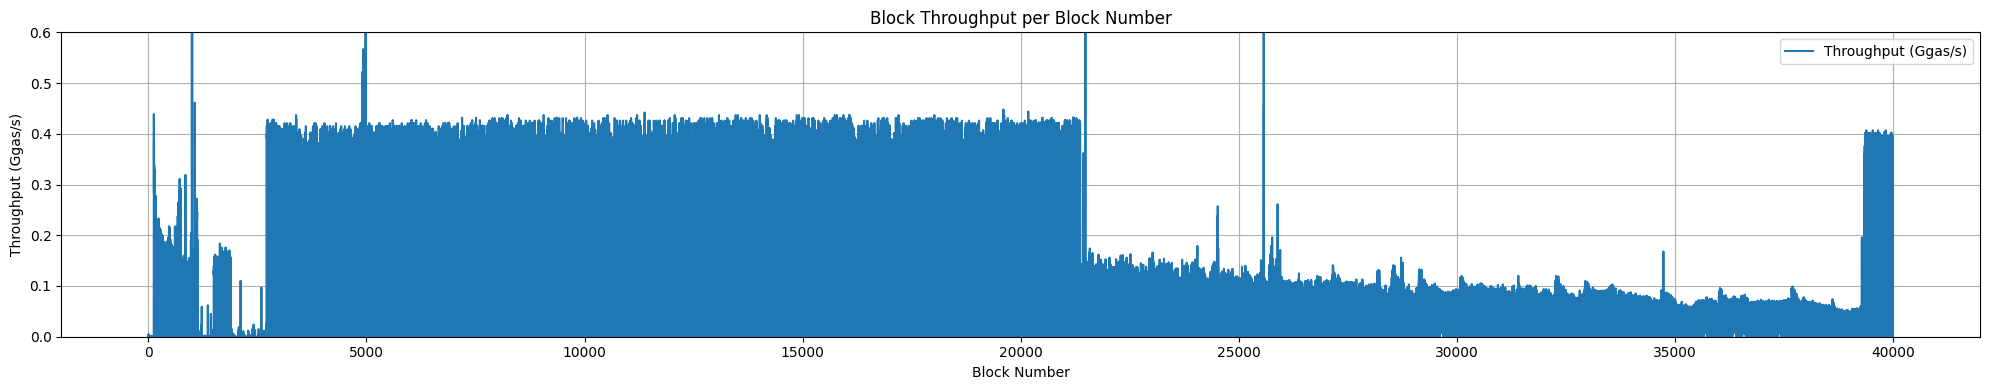

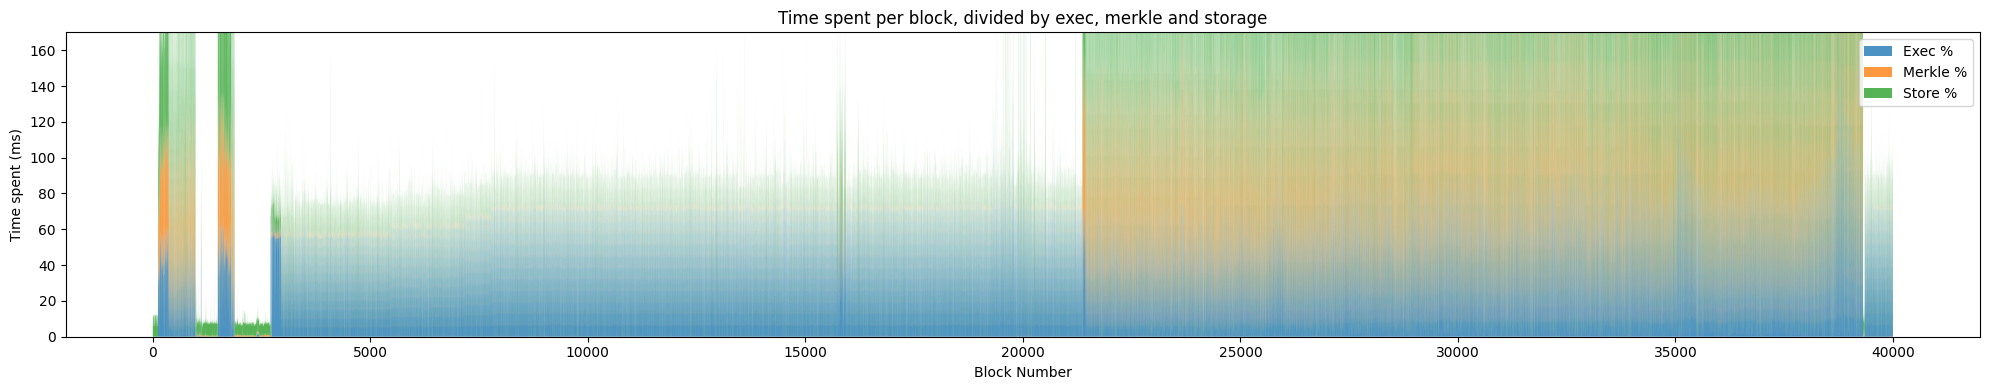

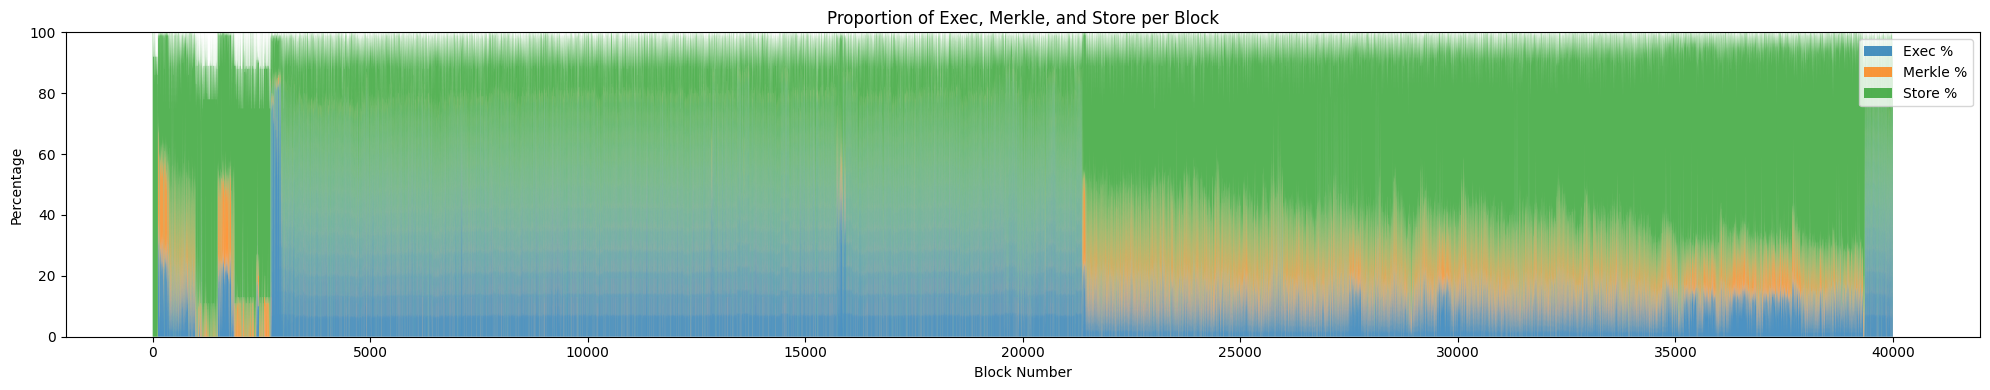

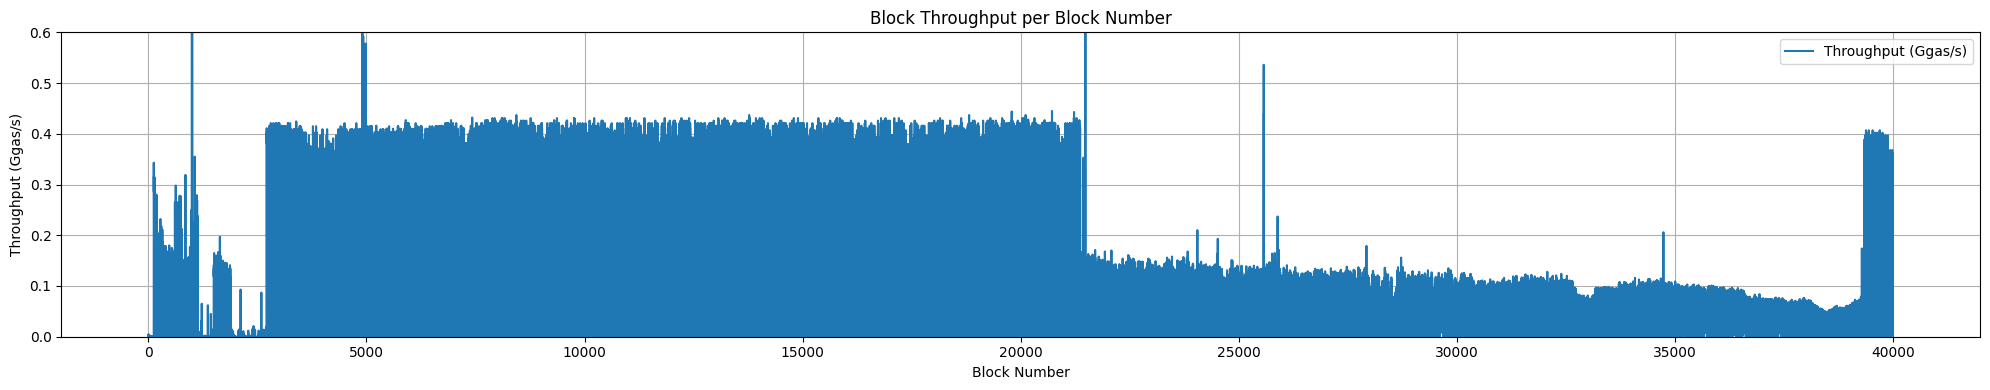

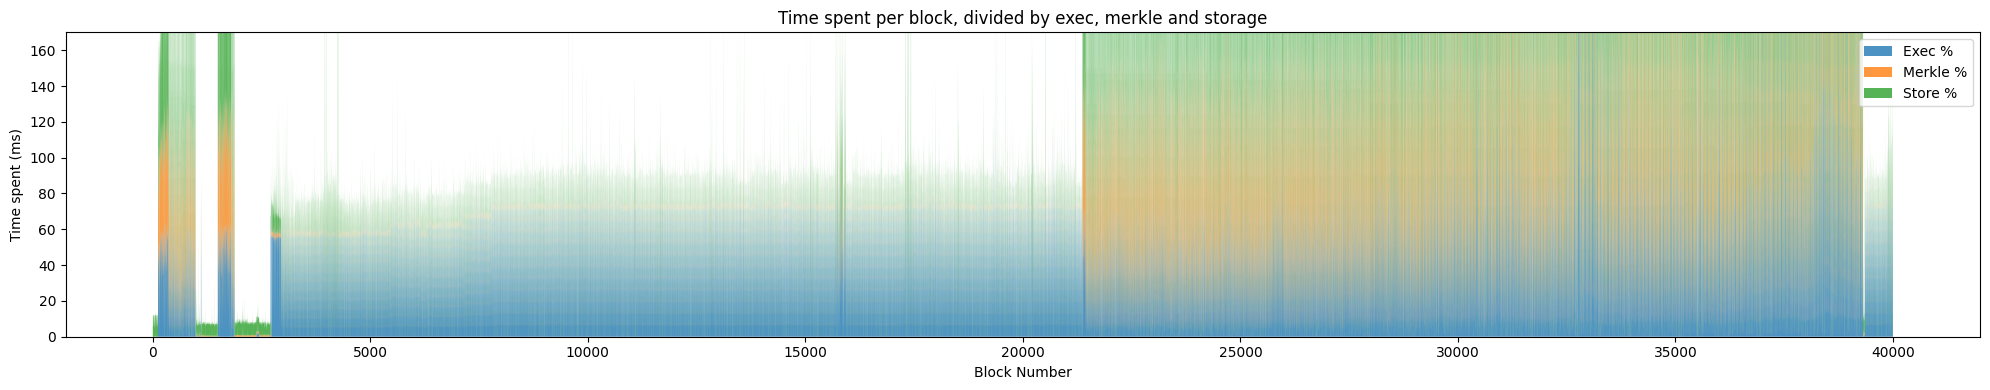

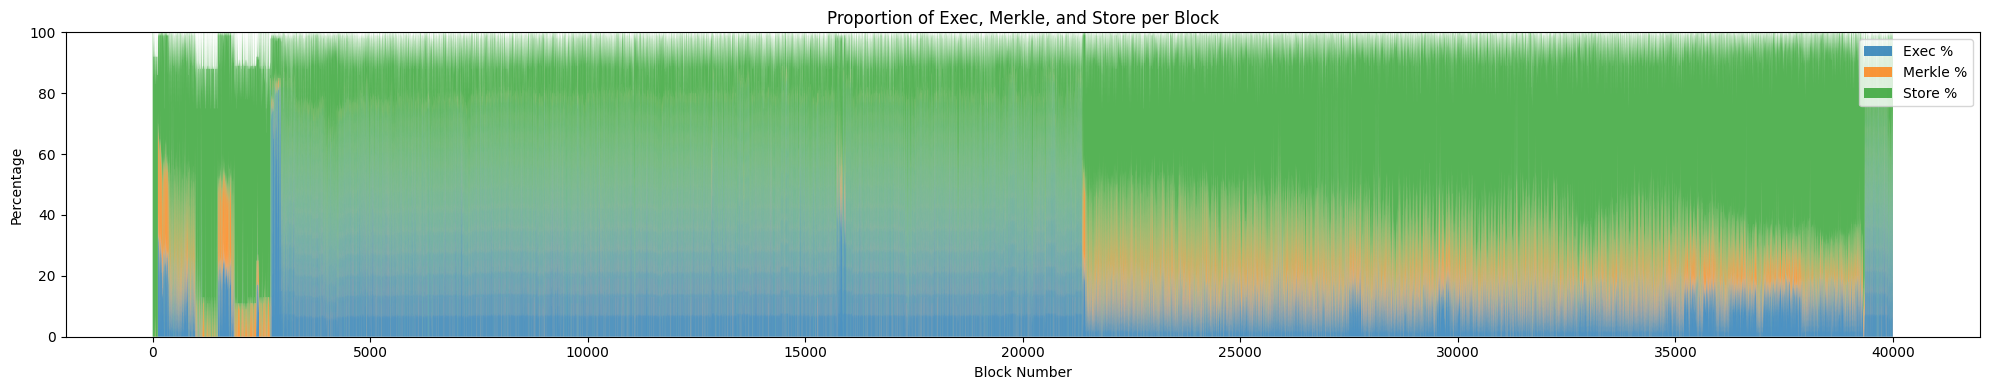

In [9]:
plot_throughput(df_main)
plot_time_spent(df_main)
plot_proportions(df_main)
plot_throughput(df_parallel)
plot_time_spent(df_parallel)
plot_proportions(df_parallel)